In [16]:
import pandas as pd
import numpy as np
import re
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib import cm
import contextily as cx
import matplotlib as mpl
from datetime import datetime
%matplotlib inline

In [26]:
def distance_from_lonlat(p1,p2):
    # https://github.com/openlayers/openlayers/blob/release-2.12/lib/OpenLayers/Util.js#L750
    #VincentyConstants
    a = 6378137
    b = 6356752.3142
    f = 1/298.257223563
    
    p1_lon = (np.pi/180) * p1[0]
    p1_lat = (np.pi/180) * p1[1]
    p2_lon = (np.pi/180) * p2[0]
    p2_lat = (np.pi/180) * p2[1]
    
    L = p2_lon - p1_lon
    U1 = np.arctan((1-f) * np.tan(p1_lat))
    U2 = np.arctan((1-f) * np.tan(p2_lat))
    
    lambda_ = L
    lambdaP = 2*np.pi
    iterLimit = 30
    
    while(np.abs(lambda_ - lambdaP) > 1e-13):
        sinSigma = np.sqrt((np.cos(U2)*np.sin(lambda_))**2 + (np.cos(U1)*np.sin(U2)- np.sin(U1)*np.cos(U2)*np.cos(lambda_))**2)
        if (sinSigma == 0):
            return 0
        cosSigma = np.sin(U1)*np.sin(U2) + np.cos(U1)*np.cos(U2)*np.cos(lambda_)
        sigma = np.arctan2(sinSigma, cosSigma)
        alpha = np.arcsin(np.cos(U1)*np.cos(U2)*np.sin(lambda_)/sinSigma)
        CSM   = cosSigma - 2*np.sin(U1)*np.sin(U2)/(np.cos(alpha)**2)
        C     = (f/16)*np.cos(alpha)**2*(4+f*(4-3*(np.cos(alpha)**2)))
        lamdaP = lambda_
        lambda_ = L + (1-C)*f*np.sin(alpha)*(sigma + C*sinSigma*(CSM + C*cosSigma*(-1 +2*CSM**2)))
        iterLimit -= 1
        if iterLimit <= 0:
                        break
    uSq = np.cos(alpha)*(a**2 - b **2)/(b**2)
    A = 1 + uSq/16384*(4096+uSq*(-768+uSq*(320-175*uSq)))
    B = uSq/1024 * (256+uSq*(-128+uSq*(74-47*uSq)))
    deltaSigma = B*sinSigma*(CSM+B/4*(cosSigma*(-1+2*CSM**2)-
    B/6*CSM*(-3+4*sinSigma*sinSigma)*(-3+4*CSM**2)))
    s = b*A*(sigma-deltaSigma)
    return s
        
import math
def merc(lat, lon):
    r_major = 6378137.000
    x = r_major * math.radians(lon)
    scale = x/lon
    y = 180.0/math.pi * math.log(math.tan(math.pi/4.0 + lat * (math.pi/180.0)/2.0)) * scale
    return (x, y)
                                 
        
def discard_outliers_from_path(x,center_lon, center_lat, deg_extent):
    results = []
    for coords in x:
        if( (np.abs(coords[0] - center_lon) < deg_extent) and (np.abs(coords[1] - center_lat) < deg_extent)):
            results.append(coords)
    return results    

def get_index(lon, lat, delta_lon, delta_lat, min_lon, min_lat):
    lon_idx = int((lon - min_lon)/delta_lon)
    lat_idx = int((lat - min_lat)/delta_lat)
    return lon_idx, lat_idx

def generate_heatmap_data(df, data_type, center_lon = -76.9388, center_lat = 38.9896, deg_extent = 0.025,
    bin_side_length = 8):


    min_lon = center_lon - deg_extent
    max_lon = center_lon + deg_extent
    min_lat = center_lat - deg_extent
    max_lat = center_lat + deg_extent


    x_min, y_max = merc(max_lat,max_lon)
    x_max, y_min =  merc(min_lat,min_lon)

    dist_x = distance_from_lonlat([max_lon,max_lat],[min_lon,max_lat])
    dist_y = distance_from_lonlat([max_lon,max_lat],[max_lon,min_lat])


    lat_size = int(np.ceil((dist_y)/bin_side_length))
    lon_size = int(np.ceil((dist_x)/bin_side_length))

    lon_list = np.linspace(min_lon,max_lon, lon_size)
    lat_list = np.linspace(min_lat,max_lat, lat_size)


    delta_lon = lon_list[1] - lon_list[0]
    delta_lat = lat_list[1] - lat_list[0]

    all_points = [] 
    if data_type == 'path':
        path_list = df['PATH'][:]
        path = []
        for str in path_list:
            path.extend(re.findall(r"[+-]? *(?:\d+(?:\.\d*)?|\.\d+)(?:[eE][+-]?\d+)?", str))
        path = list(map(float,path))
        zipped = list(zip(path[::2],path[1::2]))
    elif data_type == 'startend':
        lon_list_dt = list(map(float,pd.concat([df['START LONG'][:] , df['END LONG'][:]])))
        lat_list_dt = list(map(float,pd.concat([df['START LAT'][:] , df['END LAT'][:]])))
        zipped = list(zip(lon_list_dt,lat_list_dt))
    elif data_type == 'start':
        lon_list_dt = list(map(float,df['START LONG'][:]))
        lat_list_dt = list(map(float,df['START LAT'][:])) 
        zipped = list(zip(lon_list_dt,lat_list_dt))
    elif data_type == 'end':
        lon_list_dt = list(map(float,df['END LONG'][:]))
        lat_list_dt = list(map(float,df['END LAT'][:]))
        zipped = list(zip(lon_list_dt,lat_list_dt))
    else: 
        assert 1==2, data_type + " is not a valid data type"
        
    all_points.extend(discard_outliers_from_path(zipped,center_lon, center_lat, deg_extent))
    all_points = np.array(all_points)   

    points_map = np.ones((lon_list.size,lat_list.size))
    for point in all_points:
        points_map[get_index(point[0], point[1], delta_lon, delta_lat, min_lon, min_lat)] += 1
    west, south, east, north = (
    center_lon - deg_extent,
    center_lat - deg_extent,
    center_lon + deg_extent,
    center_lat + deg_extent
             )
    return points_map, west, south, east, north, x_min, x_max, y_max, y_min

def plot_heatmap_data(points_map,west, south, east, north, x_min, x_max, y_max, y_min,lod = 2,
    log_scale = True,cmap = mpl.cm.jet):

    img, ext = cx.bounds2raster(west,
                                 south,
                                 east,
                                 north,
                                 "map.svg",
                                 source=cx.providers.Esri.WorldStreetMap(apiKey='AAPK8b5fa650819c4801bebdefa5a1713b90OFUuzP3MP-L84q66A4FBSolubI6QYaE4BjOLNiO5OvkDmO8IWpViq_qKaN0YWJot'),
                                 ll=True
                                )
    if log_scale:
        points_map = np.log10(points_map)

    alpha_map = points_map/np.max(points_map)

    v_min = np.min(points_map)
    v_max = np.max(points_map)

    norm = mpl.colors.LogNorm(vmin=10**v_min, vmax=10**v_max)


    fig, ax = plt.subplots(figsize=(12,12))
    #x_min, y_max = tilemapbase.project(max_lon,max_lat)
    #x_max, y_min = tilemapbase.project(min_lon,min_lat)

    rots = 1

    plt.imshow(img,extent=ext)
    ax.imshow(np.rot90(points_map,rots),
        extent=(x_max, x_min, y_min, y_max),
        alpha= 0.025 + lod*np.rot90(alpha_map,rots),  # allows the background image show-through
        zorder=10,    # make this layer on top
        cmap =cmap
    )
    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap))

def is_weekday(timestamp):
    dt = datetime.fromisoformat(timestamp)
    if dt.weekday() < 5:
        return True
    else:
        return False
    
def return_year(timestamp):
    dt = datetime.fromisoformat(timestamp)
    return dt.year

def 

In [18]:
df = pd.read_csv("Data_Lv3_UMDOTS_Escooters.csv")

In [27]:

df_weekend = df[df['CREATED'].apply(is_weekday) == False]
df_weekday = df[df['CREATED'].apply(is_weekday)]
df_2019    = df[df['CREATED'].apply(return_year) == 2019]
df_2020    = df[df['CREATED'].apply(return_year) == 2020]

In [28]:
points_map, west, south, east, north, x_min, x_max, y_max, y_min = generate_heatmap_data(df_weekday, 'path')

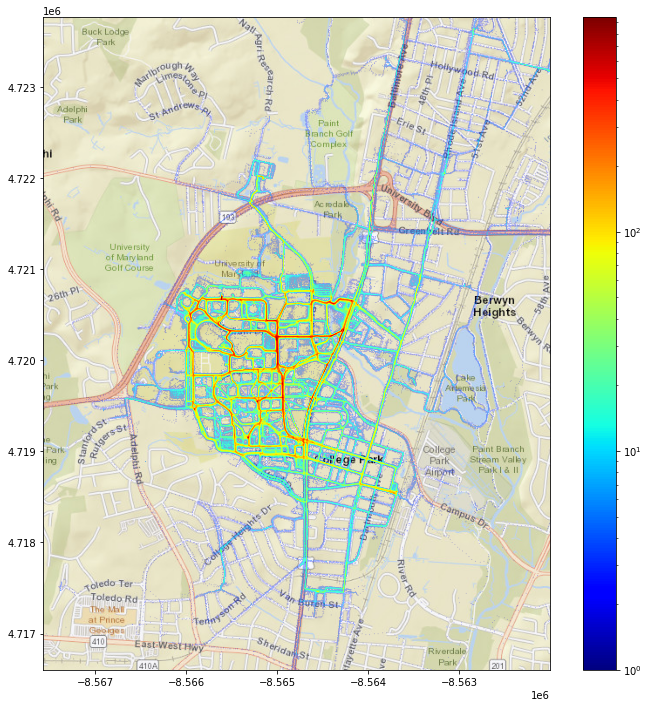

In [29]:
plot_heatmap_data(points_map, west, south, east, north, x_min, x_max, y_max, y_min)

In [159]:
import csv

with open('heatmap.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(["lon","lat","intensity"])
    for i in range(len(lon_list)):
        for j in range(len(lat_list)):
            write.writerow([lon_list[i],lat_list[j], points_map[i,j]])
f.close()